In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import csv

In [15]:
def save_weights_to_csv(weights, filename="weights.csv"):
    """
    Save the weights to a CSV file in a horizontal format.

    Parameters:
        weights (np.ndarray): The weights array.
        filename (str): The name of the output CSV file. Defaults to 'weights.csv'.
    """
    # Ensure weights are in a numpy array for consistency
    weights = np.array(weights)
    
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(weights)

    print(f"Weights successfully saved to {filename}")

def calculate_accuracy(w, X, Y):
    """
    Calculate the accuracy of the PLA model given weights, inputs, and labels.

    Args:
    - w: Weight vector (1D NumPy array).
    - X: Input data (2D NumPy array where each row is a data point).
    - Y: Labels (1D NumPy array with +1 or -1 for each data point).

    Returns:
    - accuracy: The fraction of correctly classified examples (0.0 to 1.0).
    """
    # Calculate predictions
    predictions = np.sign(np.dot(X, w))
    
    # Count correct predictions
    correct_predictions = np.sum(predictions == Y)
    
    # Calculate accuracy
    accuracy = correct_predictions / len(Y)
    return accuracy

def process_full_file(file_path, label):
    """
    Processes an entire file of boolean sequences at once.
    
    Args:
    - file_path: Path to the input file.
    - label: Classification label for sequences (+1 or -1).
    
    Returns:
    - X: 2D NumPy array of boolean sequences.
    - Y: 1D NumPy array of labels.
    """
    try:
        sequences = []
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if not line:  # Skip empty lines
                    continue
                sequences.append(list(map(int, line)))
        
        # Convert to NumPy arrays
        X = np.array(sequences, dtype=bool)
        Y = np.array([label] * len(sequences), dtype=int)
        return X, Y
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None, None
    except ValueError as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None

In [2]:
if __name__ == "__main__":
    positive_file = "16S_boolean_sequences.txt"
    negative_file = "18S_boolean_sequences.txt"

    # Process files
    X_pos, Y_pos = process_full_file(positive_file, label=1)
    X_neg, Y_neg = process_full_file(negative_file, label=-1)
    
    if X_pos is not None and X_neg is not None:
        # Combine the datasets
        X_unsplit = np.vstack((X_pos, X_neg))
        Y_unsplit = np.hstack((Y_pos, Y_neg))
        
        # Randomize the order of X and Y
        permutation = np.random.permutation(len(Y_unsplit))
        X_unsplit = X_unsplit[permutation]
        Y_unsplit = Y_unsplit[permutation]

        # Split data: 20% for testing, 80% for training
        split_idx = int(len(Y_unsplit) * 0.8)
        X, X_test = X_unsplit[:split_idx], X_unsplit[split_idx:]
        Y, Y_test = Y_unsplit[:split_idx], Y_unsplit[split_idx:]
        
        # Output shapes for verification
        print(f"X shape: {X.shape}")
        print(f"Y shape: {Y.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"Y_test shape: {Y_test.shape}")
    else:
        print("Error in processing files.")

X shape: (31643, 9600)
Y shape: (31643,)
X_test shape: (7911, 9600)
Y_test shape: (7911,)


In [8]:
# Initialize weights as zero.
w = np.zeros(X.shape[1])

# Setup PLA
iterations = 200
accuracy_record = []
accuracy_record.append(calculate_accuracy(w, X, Y))
print("Initial Accuracy:",accuracy_record[0])
print(w,f"\n")

# Perform PLA
for i in tqdm(range(iterations), desc="Running PLA", unit=" Iteration", ncols=500):
    misclassified = 0
    
    # go through every item in X
    for j in range(len(X)):
        if np.sign(np.dot(w, X[j])) != Y[j]:
            # update weights
            w = w + X[j]*Y[j]
            misclassified += 1
            
    accuracy_record.append((len(X)-misclassified)/len(X)) # Appends accuracy for this iteration
    if misclassified == 0: # If we classified everything right, end early.
        print("PLT converged in", i, "iterations")
        break

print(w)
print("Completed Accuracy:",calculate_accuracy(w, X, Y))

Initial Accuracy: 0.0
[0. 0. 0. ... 0. 0. 0.] 



Running PLA:   0%|                                                                                            …

PLT converged in 134 iterations
[-36. -16.  18. ...   0.   0.   0.]
Completed Accuracy: 1.0


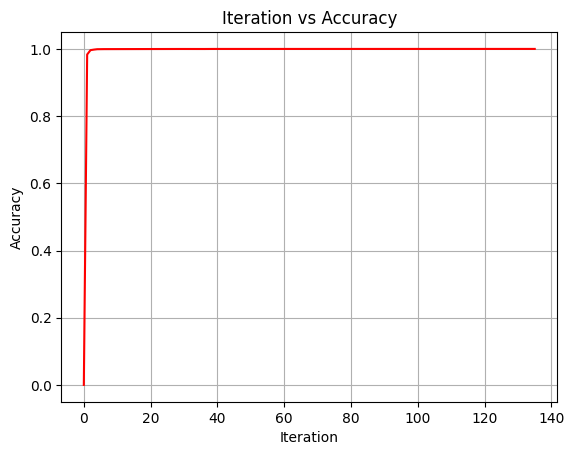

In [12]:
# Select every other value from the list
accuracy_record_reduced = accuracy_record[::2]

# X values are the indices of the reduced list
record_x_reduced = list(range(0, len(accuracy_record), 1))

# Plot the graph
plt.plot(record_x_reduced, accuracy_record, marker='', linestyle='-', color='r')

# Add labels and title
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iteration vs Accuracy")
plt.grid()

# Display the plot
plt.show()

In [14]:
# Save and check accuracy on test set
save_weights_to_csv(w)
print(f"Test set accuracy: {calculate_accuracy(w, X_test, Y_test)}")

Test set accuracy: 0.9940589053217039
